##**Library Imports**

In [ ]:
import pandas as pd
import numpy as np
import math
import string
import re

from collections import namedtuple, Counter
import json

from IPython.display import Markdown, display
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import cycle

from tqdm import tqdm
import time
from os import path
import sys

if 'transformers' not in sys.modules:
  !{sys.executable} -m pip install transformers

from transformers import BertTokenizerFast, BertForQuestionAnswering, BatchEncoding, get_linear_schedule_with_warmup

import torch
import torch.nn as nn


## **SQuAD 2.0 download and preprocessing**

In [ ]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O dev-v2.0.json

--2022-03-02 16:17:53--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   204MB/s    in 0.2s    

2022-03-02 16:17:55 (204 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2022-03-02 16:17:55--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.109.153, 185.199.111.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

Dataset creation for both **train** and **dev** sets of SQuAD 2.0  by parsing their **JSON** representations. Each dataset contains the **context text**, the **question text**, the **answer start and end indices of the characters** in the context (they are fixed in case of misalignment) and the **text for every valid answer** (the main answer is considered to be the first one and is seperated from the other answers)

In [ ]:
# Start and end positions for some answers are not aligned to the real context by one or two characters
def fixAnswerAlignment(context, answer, answer_start_idx, answer_end_idx):
  for i in range(3):
    if context[(answer_start_idx - i):(answer_end_idx + 1 - i)] == answer:
      return answer_start_idx - i, answer_end_idx - i

def parseSquad(squad_file):
  with open(squad_file, 'rb') as f:
    squad_json = json.load(f)

  mode = squad_file.split('-')[0]
  squad_list = []

  for section in squad_json['data']:
    for paragraph in section['paragraphs']:
      context = paragraph['context'].strip()
      for qa in paragraph['qas']:
          question = qa['question'].strip()
          answers = qa['answers'] if not qa['is_impossible'] else None
          if answers is not None and len(answers) > 0:
            # Always the first answer is selected as the main answer
            answer = answers[0]['text'].strip()
            answer_start_idx = answers[0]['answer_start']
            answer_end_idx = answer_start_idx + len(answer) - 1
            answer_start_idx, answer_end_idx = fixAnswerAlignment(context, answer, answer_start_idx, answer_end_idx)
            # The other answers are also included only for the evaluation/dev dataset
            other_answers = [answers[i]['text'].strip() for i in range(1, len(answers))] if mode == 'dev' else None
            squad_list.append({'context': context, 'question': question, 'answer': answer, 'answer_start_idx': answer_start_idx, 'answer_end_idx': answer_end_idx, 'other_answers': other_answers})
          else:
            squad_list.append({'context': context, 'question': question, 'answer': None, 'answer_start_idx': -1, 'answer_end_idx': -1, 'other_answers': None})

  return pd.DataFrame(squad_list, columns = ['context', 'question', 'answer', 'answer_start_idx', 'answer_end_idx', 'other_answers']).dropna(axis = 1, how = 'all') 


In [ ]:
training_set = parseSquad('train-v2.0.json') #.sample(frac = 0.8, random_state = 1).sort_index()
validation_set = parseSquad('dev-v2.0.json')

display(training_set.head(10))
print(f'Training set size: {len(training_set)}')
display(validation_set.head(10))
print(f'Validation set size: {len(validation_set)}')

,context,question,answer,answer_start_idx,answer_end_idx
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,285
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,225
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,529
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,179
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,285
5,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what R&B group was she the lead singer?,Destiny's Child,320,334
6,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What album made her a worldwide known artist?,Dangerously in Love,505,523
7,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,Who managed the Destiny's Child group?,Mathew Knowles,360,373
8,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyoncé rise to fame?,late 1990s,276,285
9,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What role did Beyoncé have in Destiny's Child?,lead singer,290,300


Training set size: 130319


,context,question,answer,answer_start_idx,answer_end_idx,other_answers
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,159,164,"[France, France, France]"
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,94,116,"[in the 10th and 11th centuries, 10th and 11th..."
2,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256,282,"[Denmark, Iceland and Norway, Denmark, Iceland..."
3,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,308,312,"[Rollo, Rollo, Rollo]"
4,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,10th century,671,682,"[the first half of the 10th century, 10th, 10th]"
5,The Normans (Norman: Nourmands; French: Norman...,Who gave their name to Normandy in the 1000's ...,None,-1,-1,None
6,The Normans (Norman: Nourmands; French: Norman...,What is France a region of?,None,-1,-1,None
7,The Normans (Norman: Nourmands; French: Norman...,Who did King Charles III swear fealty to?,None,-1,-1,None
8,The Normans (Norman: Nourmands; French: Norman...,When did the Frankish identity emerge?,None,-1,-1,None
9,"The Norman dynasty had a major political, cult...",Who was the duke in the battle of Hastings?,William the Conqueror,1022,1042,"[William the Conqueror, William the Conqueror]"


Validation set size: 11873


##**Fine tuning Bert for question answering in SQuAD 2.0**

Checking for **GPU availability**. GPU is a very powerful resource for running similar tasks which use deep neural architectures like transformers

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on GPU/Cuda' if torch.cuda.is_available() else 'Running on CPU')

Running on GPU/Cuda


The two most common **metrics** to evaluate the question answering performance in SQuAD are the **Exact Match score** and the **f1 score**. The implementation of those scores is inspired by the squad_metrics.py of the Hugging Face library

In [ ]:
def normalize_text(text):
    # Lowercasing and punctuation removal
    normalized_text = "".join(ch.lower() for ch in text if ch not in set(string.punctuation))
    # Article removal
    article_regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    normalized_text = re.sub(article_regex, " ", normalized_text)
    # Whitespace removal
    normalized_text = " ".join(normalized_text.split())

    return normalized_text

def exact_match_score(pred_answer, gold_answer):
    return int(normalize_text(pred_answer) == normalize_text(gold_answer))

def f1_score(pred_answer, gold_answer):
  pred_tokens = normalize_text(pred_answer).split()
  gold_tokens = normalize_text(gold_answer).split()
  
  # if either the prediction or the ground truth is no-answer then f1 = 1 if they agree and 0 otherwise
  if len(pred_tokens) == 0 or len(gold_tokens) == 0:
      return int(pred_tokens == gold_tokens)
  
  common = Counter(gold_tokens) & Counter(pred_tokens)
  num_same = sum(common.values())
  
  # If there are no common tokens then f1 = 0
  if num_same == 0:
    return 0
  
  precision = 1.0 * num_same / len(pred_tokens)
  recall = 1.0 * num_same / len(gold_tokens)
  
  return 2 * (precision * recall) / (precision + recall)

Useful function for  **perfomance visualization**. This function is used for plotting **learning curves** (loss vs epochs)

In [ ]:
def plotLearningCurves(x_axis, y_axis, x_label, y_label, curve_ids, legend_loc = 'lower right', x_best = None, y_best = None):
  fig = plt.figure(figsize = (7, 7))
  if x_best is not None and y_best is not None:
    ax = fig.add_subplot(111)
    ax.annotate('Best score ' + str(x_best), xy = (x_best, y_best), arrowprops = dict(facecolor = 'black', shrink = 0.05))
  for y, id in zip(y_axis, curve_ids):
    plt.plot(x_axis, y, label = id,  linewidth = 3)
  plt.title('Learning Curves')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(loc = legend_loc)
  plt.show()

 Popular **learning rate scheldulers**. **Linear warmup** schelduler is the most used by Bert

In [ ]:
scheldulers = {
  'Exponential': lambda optimizer, step: torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.1 ** (epoch / step)), # Initial lr* 0.1^(t/step)
  'Power': lambda optimizer, step: torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1 / (1 + epoch / step)), # Initial lr/ (1 + t/step)
  'Piecewise': lambda optimizer, milestones:  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = milestones, gamma = 0.1), # lr for 1 <= epoch < m1, lr*0.1 for m1 <= epoch < m2 ...
  'Performance': lambda optimizer, patience, factor : torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = patience, factor = factor),
  'OneCycle': lambda optimizer, steps_per_epoch, epochs, max_lr : torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = max_lr, anneal_strategy = 'linear', steps_per_epoch = steps_per_epoch, epochs = epochs),
  'LinearWarmup': get_linear_schedule_with_warmup
}

Some useful **building blocks** are specified in order to help with the development of the actual Bert model. At first, the initial SQuAD datasets must be **transformed** to a format that Bert "understands" (e.g token ids, segment ids, attention mask). For that reason a new **custom dataset** is created that **keeps the reference** to the initial dataset and stores all the SQuAD records of that initial dataset into some encoded Bert based records. The encoding is achieved using the encode for Bert method. This method performs the **tokenization** and the **truncation** to produce the **input tokens** and also creates the **segment ids** and the **attention mask** from the extracted tokens. Meanwhile, it **translates/maps** the above character based answer spans of the context to **token based spans** in order to indicate the start and the end positions to the Bert model. The information for every SQuAD record is stored in an encoding instance and this instance is used either to **create a record** in a format that is acceptable by Bert as mentioned above or to perform a functionality that also requires a mapping and is **related to the initial dataset** (e.g building an answer span from predictions for a specific record of the dataset). Finally, one problem is that the input lengths might differ and some padding must also be applied. In order to reduce **memory space** and **excecution time** (and better results) some external functions are specified to apply the **padding dynamically**. Dynamic padding adds some 0s to all the above encodings up to the **longest length** in the currently processed by the model batch.

In [ ]:
# Custom dataset for SQuAD
class BertSquadDataset(torch.utils.data.Dataset):
  # A SQuAD record factory/generator 
  BertSquadRecord = namedtuple('BertSquadRecord', ['input_ids', 'token_type_ids', 'attention_mask', 'start_position', 'end_position', 'squad_id'])
  
  tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

  def __init__(self, squad_df, max_length = None):
    self.squad_encodings = []
    self.max_length = max_length
    self.squad_df = squad_df

    for row in squad_df.itertuples():
      self.add_item(row.context, row.question, row.answer_start_idx, row.answer_end_idx, row.Index)
      
  def __len__(self):
    return len(self.squad_encodings)

  def __getitem__(self, idx):
    return BertSquadDataset.BertSquadRecord(**self.squad_encodings[idx])

  def add_item(self, context, question, answer_start_idx, answer_end_idx, squad_id = None):
    encoding = BertSquadDataset.createBertSquadEncoding(context, question, answer_start_idx, answer_end_idx, self.max_length)
    encoding.update({'squad_id': squad_id})
    self.squad_encodings.append(encoding)
  
  # Constructs an answer for a specific record in the dataset given a span (it is mostly used to construct the predicted answer of Bert)
  def buildBertAnswer(self, idx, start_position, end_position):
    # Start position cannot be after the end position
    if start_position > end_position:
      return None
    
    # No answer
    if start_position == 0 and end_position == 0:
      return ''

    # The encoding that is stored for the specific squad record
    encoding = self.squad_encodings[idx]
    input_ids = encoding.input_ids

    # The first context token is located right after the first occurance of the SEP token
    context_start_token_idx = input_ids.index(BertSquadDataset.tokenizer.sep_token_id) + 1
    # The last context token is located right before the last SEP token
    context_end_token_idx = len(input_ids) - 2

    # If the start of the span is out of the context then there is no answer (it is not acceptable for an answer to start in a question or a padding area)
    if start_position < context_start_token_idx or start_position > context_end_token_idx:
      return None
    
    # If the end of the span is out of the context then it can be truncated to the end of the context (i.e whenever the answer contains some padding it can be removed)
    end_position = min(end_position, context_end_token_idx)

    # Encoding keeps the offset mapping
    answer_start_idx = encoding.token_to_chars(start_position)[0]
    answer_end_idx = encoding.token_to_chars(end_position)[1]

    context = self.squad_df['context'][idx]
    answer_in_context = context[answer_start_idx:answer_end_idx]

    return answer_in_context
  
  @staticmethod
  def encodeSquadForBert(context, question, answer_start_idx, answer_end_idx, max_length = None):
    # Whenever max length is given then truncation is applied only to context/passage
    truncation = 'only_second' if max_length else False

    encoding = BertSquadDataset.tokenizer(question, context, max_length = max_length, truncation = truncation, return_offsets_mapping = True)
    # Initialization of the start and end positions ((0, 0) indicates the CLS token which is used when an answer cannot be found)
    encoding.update({'start_position': 0, 'end_position': 0})
    # This mapping will be used instead of the char_to_token and token_to_char functions of the encoding for more flexibility
    offset_mapping = encoding.pop('offset_mapping')

    # If either the start or the end of the answer is missing then start and end positions cannot be found 
    if answer_start_idx < 0 or answer_end_idx < 0:
      return encoding
    
    # The first context token is located right after the first occurance of the SEP token
    context_start_token_idx = encoding['input_ids'].index(BertSquadDataset.tokenizer.sep_token_id) + 1
    # The last context token is located right before the last SEP token
    context_end_token_idx = len(encoding['input_ids']) - 2
    
    context_start_idx = offset_mapping[context_start_token_idx][0]
    context_end_idx = offset_mapping[context_end_token_idx][1] - 1

    # If the answer is out of the context bounds (e.g has been truncated) there is no reason to search for its start and end positions
    if context_start_idx > answer_start_idx or context_end_idx < answer_end_idx:
      return encoding
    
    # Start and end positions are calculated in such a way to cover the whole answer without losing information
    # But sometimes a bad tokenization can add a little noise if some tokens include both some characters of the answer and some characters out of the answer

    start_position = context_start_token_idx
    while offset_mapping[start_position][1] - 1 < answer_start_idx:
      start_position += 1
    
    end_position = context_end_token_idx
    while offset_mapping[end_position][0] > answer_end_idx:
      end_position -= 1
    
    encoding.update({'start_position': start_position, 'end_position': end_position})

    return encoding
  
  @staticmethod
  def createBertSquadEncoding(context, question, answer_start_idx, answer_end_idx, max_length = None):
    encoding = BertSquadDataset.encodeSquadForBert(context, question, answer_start_idx, answer_end_idx, max_length)
    return encoding

def padSequence(batch, padding_value = 0): 
  max_len = max([len(x) for x in batch])
  batch_padded = []
  for x in batch:
    x_padded = [padding_value] * max_len
    x_padded[:len(x)] = x
    batch_padded.append(x_padded)
    
  return batch_padded

# Collate function that is going to be used by the Dataloader in order to add padding to each batch
def padCollate(batch, padding_value = 0):
  (batch_input_ids, batch_token_type_ids, batch_attention_masks, batch_start_positions, batch_end_positions, batch_ids) = zip(*batch)

  batch_labels = {
      'start_positions': torch.tensor(batch_start_positions, device = device),
      'end_positions': torch.tensor(batch_end_positions, device = device)
  } 
  
  # Padding all the sequences to have equal lengths (the length is equal to the length of the longest sequence in the batch)
  # Padding is applied to the segment ids and the attention masks as well
  batch_padded_features = {'input_ids': padSequence(batch_input_ids), 
                           'token_type_ids': padSequence(batch_token_type_ids),
                           'attention_mask': padSequence(batch_attention_masks)
                          }
  
  return BatchEncoding(batch_padded_features, tensor_type = 'pt').to(device), batch_labels, batch_ids
          

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

This is the actual class of the **Bert for SQuAD Question Answering**. This class is a wrapper of the **BertForQuestionAnswering** which is already implemented and provided by the Hugging Face library and has been extended with some extra functionalities in order to automate all the training and evaluation process as much as possible. Especially, at the evaluation stage the above metrics (Extact Match and f1 score) are incoorporated for **calculating the scores** for the every single record in the validation/dev dataset. In order the model to predict better answers there is a kind of a **mini exhaustive search** between the **top k** (k is predefined and it can be an extra hyperparameter) possible and fisible spans. Furthermore, there are two functions for **training**, both supporting **gradient clipping**, but the one with the more options (stats, early stopping etc...) it is going to be used below. Moreover, these functions support **learning rate schelduling** and they call in every epoch the **batch** training submethod to train all the batches. Finally, there is one method for making predictions for any given unseen input but using a naive method to extract them

In [ ]:
class BertForSquad(nn.Module):

    def __init__(self):
        super().__init__()
        
        # Instantiate Bert for QA
        self.bert = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

    def forward(self, bertInputConfig, start_positions = None, end_positions = None):

        out = self.bert(**bertInputConfig, start_positions = start_positions, end_positions = end_positions)
            
        return out
    
    def batchTrain(self, batch_loader, optimizer, schelduler = None, max_clip_norm = None):
      total_loss = 0.0

      for x_batch, y_batch, _ in tqdm(batch_loader, 'Batch Training'):
        # Gradients are restored to zero
        optimizer.zero_grad()
        
        pred = self(x_batch, **y_batch)

        loss = pred.loss

        total_loss += loss.item()
        
        # Backpropagation starting from the loss calculated in this epoch
        loss.backward()
        # Gradient clipping
        if max_clip_norm is not None:
          nn.utils.clip_grad_norm_(self.parameters(), max_clip_norm)
        # Model's weights update based on the gradients calculated during backprop
        optimizer.step()

        # Some scheldulers can make steps inside the batches such as OneCycle schelduler
        if schelduler is not None:
          schelduler.step()
          #print(schelduler.state_dict())

      return total_loss / len(batch_loader) # Average loss
    
    def batchEval(self, batch_loader, search_best_span_limit = 20):
          total_loss = 0.0
          total = 0.0
          em_scores = 0.0
          f1_scores = 0.0

          with torch.no_grad():
            for x_batch, y_batch, batch_ids in tqdm(batch_loader, 'Batch Evaluation'):
              pred = self(x_batch, **y_batch)

              loss = pred.loss
              start_logits = pred.start_logits
              end_logits = pred.end_logits
                
              total_loss += loss.item() 

              # Instead of using `pred_start_positions = torch.argmax(start_logits, dim = 1)` to find the best start that might be invalid, the range is extended to the top k
              pred_start_indices = torch.topk(start_logits, search_best_span_limit, dim = 1).indices.cpu().detach().numpy()
              # Instead of using `pred_end_positions = torch.argmax(end_logits, dim = 1)` to find the best end that might be invalid, the range is extended to the top k
              pred_end_indices = torch.topk(end_logits, search_best_span_limit, dim = 1).indices.cpu().detach().numpy()

              #pred_spans = torch.cat([pred_start_positions.unsqueeze(1), pred_end_positions.unsqueeze(1)], dim = 1).cpu().detach().numpy()

              for i, (starts, ends) in enumerate(zip(pred_start_indices, pred_end_indices)):
                id = batch_ids[i]
                pred_answer = None
                best_span_score = float('-inf')
                # Searching for a fisible span with the best score
                for start in starts: 
                  for end in ends:
                    sum = start_logits[i][start] + end_logits[i][end]
                    if sum.item() > best_span_score:
                      span_text = batch_loader.dataset.buildBertAnswer(id, start, end)
                      if span_text is not None: # If answer is valid
                        pred_answer = span_text
                        best_span_score = sum
                
                if pred_answer is None: # If no valid answer found at all
                  pred_answer = '' 

                answer = batch_loader.dataset.squad_df['answer'][id]
                if answer is not None:
                  other_answers = batch_loader.dataset.squad_df['other_answers'][id] or []
                  all_answers = [*other_answers, answer]
                else:
                  all_answers = ['']
                # Calculation of the Exact Match score and f1 score between the predicted answer and all the gold/ground truth answers  
                em_scores += max((exact_match_score(pred_answer, answer)) for answer in all_answers)
                f1_scores += max((f1_score(pred_answer, answer)) for answer in all_answers)
                total += 1
              
          return [total_loss / len(batch_loader), em_scores / total, f1_scores / total]
        
    def fineTuning(self, training_set, optimizer, lr_schelduler = None, max_clip_norm = None, epochs = 3, batch_size = 32):
      # Switching to training mode
      self.train()

      # Training batches
      batch_loader = torch.utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True, collate_fn = padCollate)
      
      # Creating the right schelduling function
      if lr_schelduler is not None:
        if lr_schelduler['name'] != 'Performance':
          schelduler = lr_schelduler['schelduler']
        else:
          raise Exception('Performance schelduling cannot be applied')

      for epoch in range(1, epochs + 1):
        print(f'\nEpoch: {epoch}')
        if lr_schelduler is not None and not lr_schelduler['epoch_step']:  # For OneCycle schelduler for example is better to make steps inside the batches
          loss_score = self.batchTrain(batch_loader, optimizer, schelduler, max_clip_norm)
        else:
          loss_score = self.batchTrain(batch_loader, optimizer, None, max_clip_norm)
    
        # Learning rate modification for the next epoch
        if lr_schelduler is not None and lr_schelduler['epoch_step']:
          schelduler.step()
          #print(schelduler.state_dict())
        
        print(f'Loss = {loss_score:.5f}')

    def fineTuningWithOptions(self, training_set, optimizer, validation_set = None, lr_schelduler = None, max_clip_norm = None, epochs = 3, batch_size = 32, stats = False, early_stopping_params = None):
      if validation_set is not None and (stats != False or early_stopping_params is not None or (lr_schelduler is not None and lr_schelduler['name'] == 'Performance')): 
        train_losses = []
        valid_losses = []
        valid_em_scores = []
        valid_f1_scores = []
        best_score = float('inf')
        best_iter = 1
        counter = 0
        epoch = 1

        # Training batches
        training_batch_loader = torch.utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True, collate_fn = padCollate)

        # Validation batches
        validation_batch_loader = torch.utils.data.DataLoader(validation_set, batch_size = batch_size, collate_fn = padCollate)

        # Creating the right schelduling function
        if lr_schelduler is not None:
          schelduler = lr_schelduler['schelduler']
        
        for epoch in range(1, epochs + 1): 
          if stats: 
            print(f'\nEpoch: {epoch}')
          # Switching to training mode
          self.train()
          # Batch training and calculation of the average training batch scores (accuracy score, loss, f1 score)
          if lr_schelduler is not None and not lr_schelduler['epoch_step']:  # For OneCycle schelduler for example is better to make steps inside the batches
            train_loss = self.batchTrain(training_batch_loader, optimizer, schelduler, max_clip_norm)
          else:
            train_loss = self.batchTrain(training_batch_loader, optimizer, None, max_clip_norm)

          train_losses.append(train_loss)

          # Switching to evaluation mode
          self.eval()
          # Calculation of validation batch scores
          valid_loss, valid_em_score, valid_f1_score =  self.batchEval(validation_batch_loader)

          valid_losses.append(valid_loss)
          valid_em_scores.append(valid_em_score)
          valid_f1_scores.append(valid_f1_score)

          if valid_loss < best_score:
            best_score = valid_loss
            best_iter = epoch
            counter = 0
          else: 
            counter += 1

          # If validation set starts increasing by reaching a small patience then maybe the model starts to overfit. So model training has to stop as soon as possible
          if early_stopping_params is not None and counter == early_stopping_params['patience']:
            break
          
          # Learning rate modification for the next epoch
          if lr_schelduler is not None:
            if lr_schelduler['name'] == 'Performance': # Validation loss must be passed to the performance schelduler
              schelduler.step(valid_loss)
            elif lr_schelduler['epoch_step']:
              schelduler.step()
            #print(schelduler.state_dict())

          if stats: 
            print(f'Training: Loss = {train_loss:.5f}')
            print(f'Validation: Loss = {valid_loss:.5f}, Exact match = {valid_em_score:.5f}, F1 score = {valid_f1_score:.5f}')
        
        if stats:
          # Learning curve plot
          plotLearningCurves(list(range(1, epoch + 1)), [valid_losses, train_losses], 'Number of Iterations', 'Loss', ['validation', 'training'], 'upper right', best_iter, best_score)
          
          return [train_losses, valid_losses, valid_em_scores, valid_f1_scores]
          
      elif validation_set is None and (stats != False or early_stopping_params is not None or (lr_schelduler is not None and lr_schelduler['name'] == 'Performance')): 
        raise Exception('Validation set must not be None in order to calculate stats or to do early stopping or to do performance schelduling')
      else: 
        self.fineTuning(training_set, optimizer, lr_schelduler, max_clip_norm, epochs, batch_size)
    
    def predict(self, X):
      # Switching to evaluation mode
      self.eval()
      with torch.no_grad():
          # Model computes the span of each answer
          pred = self(X)
          
          start_logits = pred.start_logits
          end_logits = pred.end_logits
          
          # A naive solution for extracting the answer
          pred_start_positions = torch.argmax(start_logits, dim = 1)
          pred_end_positions = torch.argmax(end_logits, dim = 1)

          pred_spans = torch.cat([pred_start_positions.unsqueeze(1), pred_end_positions.unsqueeze(1)], dim = 1)

          return pred_spans


Custom made function for **fine tuning** using a **grid search**

In [ ]:
def customGridSearch(param_grid, training_set, validation_set):
  i = 1
  for batch_size in param_grid['batch_sizes']:
    for learning_rate in param_grid['learning_rates']:

      model = BertForSquad().to(device)
      
      # AdamW is an improved version of Adam to better handle the weight decay factor (thats why it is prefered against Adam)
      # Default values of AdamW are the same with the values used at the pretraining phase of Bert
      optimizer = torch.optim.AdamW(model.parameters(), learning_rate['val'], weight_decay = 1e-2)

      schelduler = None
      # Creation of the schelduler with some default values (e.g steps, etc..)
      if learning_rate['schelduler']:
        total_steps = math.ceil(len(training_set) / batch_size) * param_grid['epochs']
        if learning_rate['schelduler'] == 'Exponential':
          schelduler = {'name':  'Exponential', 'schelduler': scheldulers['Exponential'](optimizer, 5), 'epoch_step': True}
        if learning_rate['schelduler'] == 'Power':
          schelduler = {'name':  'Power', 'schelduler': scheldulers['Power'](optimizer, 5), 'epoch_step': True}
        if learning_rate['schelduler'] == 'Piecewise':
          schelduler = {'name':  'Piecewise', 'schelduler': scheldulers['Piecewise'](optimizer, [0.2 * param_grid['epochs'], 0.5 * param_grid['epochs'], 0.8 * param_grid['epochs']]), 'epoch_step': True} 
        if learning_rate['schelduler'] == 'Performance':
          schelduler = {'name':  'Performance', 'schelduler': scheldulers['Performance'](optimizer, 3, 0.5), 'epoch_step': True}
        if learning_rate['schelduler'] == 'OneCycle':
          schelduler = {'name':  'OneCycle', 'schelduler': scheldulers['OneCycle'](optimizer, total_steps / param_grid['epochs'], param_grid['epochs'], learning_rate['val'] * 100), 'epoch_step': False}
        if learning_rate['schelduler'] == 'Linear': # Linear learning rate decay (thats why the warmup steps are 0) is the most popular schelduler and most used in many common tasks
          schelduler = {'name':  'Linear', 'schelduler': scheldulers['LinearWarmup'](optimizer, num_warmup_steps = 0, num_training_steps = total_steps), 'epoch_step': False}
        if learning_rate['schelduler'] == 'LinearWarmup': # Linear warmup 20% of the total steps 
          schelduler = {'name':  'LinearWarmup', 'schelduler': scheldulers['LinearWarmup'](optimizer, num_warmup_steps = 0.2 * total_steps, num_training_steps = total_steps), 'epoch_step': False} 

      curr_grid = f'Grid Search {i} Batch size: {batch_size}, Learning rate: {learning_rate["val"]}, Schelduler: {learning_rate["schelduler"] if schelduler is not None else None}'
      display(Markdown('**' + curr_grid + '**'))
      
      i += 1
      # Timekeeping the training process
      timestamp_start = time.time()
      model.fineTuningWithOptions(training_set, optimizer, validation_set, schelduler, param_grid['max_clip_norm'], param_grid['epochs'], batch_size, True, None)
      timestamp_end = time.time()
      print(f'\nTotal time: {timestamp_end - timestamp_start:.2f} seconds')


## **Model fine tuning and evaluation section**

**Training** and **validation datasets** creation including all the encoded Bert inputs of the SQuAD records. Also a max length value is defined for **length truncation**. This value is specified properly in order not to lose much information bearing in mind the memory limits as well 

In [ ]:
max_squad_length = 384
bert_training_set = BertSquadDataset(training_set, max_squad_length)
bert_validation_set = BertSquadDataset(validation_set, max_squad_length)

### **Evaluation of the basic/common hyperparameter options for fine tuning**

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

**Grid Search 1 Batch size: 8, Learning rate: 5e-05, Schelduler: Linear**


Epoch: 1


Batch Evaluation: 100%|██████████| 1485/1485 [09:34<00:00,  2.59it/s]


Training: Loss = 1.23262
Validation: Loss = 1.05639, Exact match = 0.70547, F1 score = 0.74055

Epoch: 2


Batch Evaluation: 100%|██████████| 1485/1485 [09:43<00:00,  2.54it/s]


Training: Loss = 0.64860
Validation: Loss = 1.08197, Exact match = 0.73023, F1 score = 0.76417


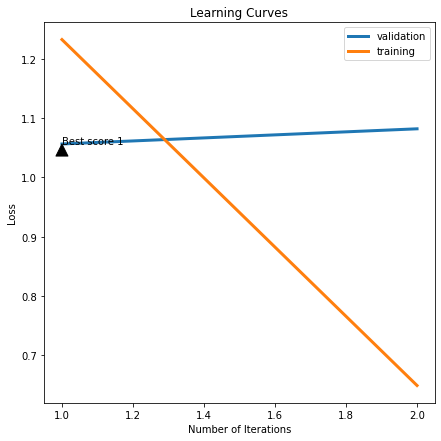


Total time: 9238.02 seconds


In [ ]:
# This grid contains only the best value but the search can be extended between many values
param_grid = {
  'batch_sizes': [8],
  'learning_rates': [{'val': val, 'schelduler': 'Linear'} for val in [5e-5]],
  'max_clip_norm': None,
  'epochs': 2,
}

customGridSearch(param_grid, bert_training_set, bert_validation_set)